# Imports

In [1]:
import os
import time
import numpy as np
from dotenv import load_dotenv
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
from spotipy import Spotify
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline

# ETL

## Definiciones 

In [2]:
def get_playlist_info(playlist: dict, genre: str):
    '''Create dict merging playlist ID and genre'''
    return {
        "id": playlist["id"],
        "genre": genre 
    }


def get_track_info(track,genre):
    '''Create dict merging track info and genre'''
    return {
        "id": track["id"],
        "name": track["name"],
        "album_id": track["album"]["id"],
        "genre":genre
    }


def get_tracks_from_playlists(playlists: pd.DataFrame, sp: Spotify,verbose:bool=False,remove_nulls:bool=True):
    '''Create a DataFrame containing track info'''
    tracks_playlists = []
    errors = []

    for idx, playlist_id in enumerate(tqdm(playlists["id"])):
        try:
            playlist_tracks = sp.playlist_tracks(playlist_id=playlist_id)
            tracks_playlist = [get_track_info(item["track"],playlists["genre"][idx]) for item in playlist_tracks["items"]]
            tracks_playlists += tracks_playlist
        except TypeError as err:
            # print(f"Error en fila {idx}", err)
            errors.append(f"Error en fila {idx}, {err}")
            continue
    if verbose:
        print('Errors: ', errors)

    df_tracks = pd.DataFrame(tracks_playlists)

    # Validation of tracks with null values
    if verbose:
        print('Null in id col of tracks:', df_tracks["id"].isna().value_counts())

    # Delete rows with null values
    if remove_nulls:
        df_tracks.dropna(inplace=True)
    
    
    return df_tracks

def get_playlists_from_list(seeds:list,limit:int,verbose:bool=False,remove_nulls:bool=True):
    '''Generates a DataFrame, each row is one of <limit> playlists for each genre in seeds'''
    playlists = []
    for genre in seeds:
        # Search playlists by genre
        if verbose:
            print('➡️', end='')
        
        playlists_data = sp.search(q=genre, type='playlist', limit=limit, offset=0)
        playlists += [
            get_playlist_info(playlist, genre)
            for playlist in playlists_data['playlists']['items']
        ]
    df_playlists = pd.DataFrame(playlists)
    # Validation of playlists with null values
    if verbose:
        print(f'Null in id col of playlists', df_playlists["id"].isna().value_counts())
    # Delete rows with null values
    if remove_nulls:
        df_playlists.dropna(inplace=True)
    
    return df_playlists

def clear_duplicates(df_tracks:pd.DataFrame, remove:bool=False):
    '''Cleans duplicates from tracks, if remove is True, deleting them; if remove is False, combining their genres into a combined string like example:
        Example: id 4fgJe7zBjVXvs8HxtE21Y9 has 2 genres: 'anime' and 'j-pop'
        We will merge them into one: 'anime,j-pop'
    '''
    if remove:
        df_tracks_clean=df_tracks.drop_duplicates(subset=["id"])
    else:
        df_tracks_clean = df_tracks.groupby(["id", "name", "album_id"])["genre"].apply(lambda x: ','.join(x)).reset_index()
    return df_tracks_clean

def get_audio_features(df_tracks:pd.DataFrame,verbose:bool=False):
    '''From dataframe with track info, get a new dataFrame with audio features for each track'''
    audio_features = []

    for n in tqdm(range(len(df_tracks) // 100 + 1)):
        df_track_pack = df_tracks.iloc[n*100:(n+1)*100]
        audio_features_pack = sp.audio_features(tracks=list(df_track_pack['id']))
        audio_features += audio_features_pack
    #Delete none before converting into DataFrame    
    audio_features = [af for af in audio_features if af is not None]
    df_audio_features = pd.DataFrame(audio_features)

    if verbose:
        idx_af_bads = []
        for idx, af in enumerate(audio_features):
            if af is None:
                idx_af_bads.append(idx)
        print('Number of None values in audio features:', len(idx_af_bads))
    
    df_tracks_audio_features = pd.merge(
        df_tracks,
        df_audio_features,
        on="id",
        how="inner"
    )

    return df_tracks_audio_features

def es_multi_genero(genre):
  return len(set(genre.split(','))) >1 

def contar_multigeneros(songs:pd.DataFrame):
    multi_g = 0 
    for genre in songs.genre:
        if es_multi_genero(genre):
            multi_g += 1
    print(multi_g, str(multi_g/songs.shape[0]*100)+'%')

## Generacion del Dataset

Cargamos las credenciales de la API de spotify

In [32]:
# Spotify API credentials
load_dotenv()
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

# Spotify API authentication
client_credentials_manager = SpotifyClientCredentials(
    client_id='494d1b2d0fa940a58d9c4ce868a2bcb3',
    client_secret='fc927c45ed74477ab8ce4e2f1c490f62'
)
sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

Armamos la lista de generos de los cuales vamos a buscar canciones

In [61]:
#Genre seeds provided by Spotify
genres_seeds = [
    "acoustic", "afrobeat", "alt-rock", "alternative", "ambient", "anime", "black-metal", "bluegrass",
    "blues", "bossanova", "brazil", "breakbeat", "british", "cantopop", "chicago-house", "children", "chill",
    "classical", "club", "comedy", "country", "dance", "dancehall", "death-metal", "deep-house", "detroit-techno",
    "disco", "disney", "drum-and-bass", "dub", "dubstep", "edm", "electro", "electronic", "emo", "folk", "forro",
    "french", "funk", "garage", "german", "gospel", "goth", "grindcore", "groove", "grunge", "guitar", "happy",
    "hard-rock", "hardcore", "hardstyle", "heavy-metal", "hip-hop", "holidays", "honky-tonk", "house", "idm", "indian", 
    "indie", "indie-pop", "industrial", "iranian", "j-dance", "j-idol", "j-pop", "j-rock", "jazz", "k-pop", "kids",
    "latin", "latino", "malay", "mandopop", "metal", "metal-misc", "metalcore", "minimal-techno", "movies", "mpb",
    "new-age", "new-release", "opera", "pagode", "party", "philippines-opm", "piano", "pop", "pop-film", "post-dubstep",
    "power-pop", "progressive-house", "psych-rock", "punk", "punk-rock", "r-n-b", "rainy-day", "reggae", "reggaeton",
    "road-trip", "rock", "rock-n-roll", "rockabilly", "romance", "sad", "salsa", "samba", "sertanejo", "show-tunes",
    "singer-songwriter", "ska", "sleep", "songwriter", "soul", "soundtracks", "spanish", "study", "summer", "swedish",
    "synth-pop", "tango", "techno", "trance", "trip-hop", "turkish", "work-out", "world-music"
]

Generamos el dataset con los audio features que provee spotify

In [ ]:
#Create dataframe with playlists id and genre
df_playlists = get_playlists_from_list(genres_seeds,10)

In [ ]:
# Save df_playlists to csv
df_playlists.to_csv('./datasets/playlists.csv', index=False)

In [22]:
tracks_playlists = get_tracks_from_playlists(playlists=df_playlists, sp=sp)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Errors:  []


In [26]:
tracks_playlists = clear_duplicates(tracks_playlists)

In [ ]:
# Save df_tracks to csv
tracks_playlists.to_csv('./datasets/tracks.csv', index=False)

In [28]:
df_tracks_audio_features = get_audio_features(tracks_playlists)

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


In [ ]:
# Save df_tracks_audio_features to csv
df_tracks_audio_features.to_csv('./datasets/tracks_audio_features.csv', index=False)

In [3]:
df_tracks_audio_features = pd.read_csv('./datasets/tracks_audio_features.csv')

Al principio elegimos muchos generos y nos resulto dificil el analisis, por lo que volvimos para filtrarlos e ir de a poco

In [4]:
genres_selected = [
    "classical", "hip-hop","jazz","pop","rock"
]
tracks_selected = df_tracks_audio_features[df_tracks_audio_features['genre'].isin(genres_selected)]

Hasta aca el dataset puede llegar a contener canciones 'multi-genero' (por como manejamos los casos de IDs duplicados). Nosotros elegimos eliminarlos porque nos complejizan el analisis.

In [5]:
contar_multigeneros(tracks_selected)

0 0.0%


In [6]:
tracks_selected=tracks_selected.drop(tracks_selected[tracks_selected.genre.apply(lambda x: es_multi_genero(x))].index)

Por otro lado, tenemos canciones que, por pertenecer a dos o mas playlists del mismo genero, tienen el genero duplicado, vamos a limpiarlos

In [7]:
tracks_selected['genre'] = tracks_selected.genre.apply(lambda x: ''.join(set(x.split(','))) )

# EDA

In [33]:
tracks_selected.columns

Index(['id', 'name', 'album_id', 'genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [48]:
tracks_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2130 entries, 18 to 67276
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id                2130 non-null   object  
 1   name              2130 non-null   object  
 2   album_id          2130 non-null   object  
 3   genre             2130 non-null   object  
 4   danceability      2130 non-null   float64 
 5   energy            2130 non-null   float64 
 6   key               2130 non-null   category
 7   loudness          2130 non-null   float64 
 8   mode              2130 non-null   category
 9   speechiness       2130 non-null   float64 
 10  acousticness      2130 non-null   float64 
 11  instrumentalness  2130 non-null   float64 
 12  liveness          2130 non-null   float64 
 13  valence           2130 non-null   float64 
 14  tempo             2130 non-null   float64 
 15  type              2130 non-null   object  
 16  uri               2130 non-

Key, Time Signature y Mode son categoricas segun la Documentacion de Spotify

In [8]:
tracks_selected['key']=tracks_selected['key'].astype('category')
tracks_selected['time_signature']=tracks_selected['time_signature'].astype('category')
tracks_selected.drop(tracks_selected[tracks_selected['time_signature']=='0'].index,inplace=True) #son 3 rancias
tracks_selected['mode']=tracks_selected['mode'].astype('category')



In [83]:
tracks_selected.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2.128000e+03
mean,0.520489,0.383445,-14.798469,0.085228,0.576137,0.434388,0.155525,0.366844,112.120859,2.256868e+05
std,0.195595,0.310701,9.402381,0.093320,0.407669,0.429908,0.124545,0.255506,32.719550,1.034847e+05
min,0.065300,0.000715,-47.903000,0.024800,0.000017,0.000000,0.022500,0.030200,47.362000,5.292900e+04
25%,0.382000,0.073375,-21.949000,0.037300,0.102750,0.000002,0.094700,0.146000,85.314000,1.672908e+05
50%,0.513000,0.335000,-12.184500,0.045450,0.756000,0.322000,0.111000,0.311000,107.217000,2.067615e+05
75%,0.667250,0.670000,-6.665250,0.075775,0.976000,0.901000,0.154000,0.563000,134.075500,2.536048e+05
max,0.967000,0.995000,-0.140000,0.741000,0.996000,0.985000,0.979000,0.974000,234.451000,1.252322e+06


Vemos que duration, tempo y loudness estan en otras escalas, por lo que vamos a normalizarlas

In [9]:
#Normalize duration from milisec to sec
tracks_selected['duration_ms'] = tracks_selected['duration_ms']/60000  

#Normalizo la variable loudness
tracks_selected['loudness'] = tracks_selected['loudness']/60


#normalizo la variable tempo
tracks_selected['tempo'] = tracks_selected['tempo']/100

In [67]:
tracks_selected["genre"].value_counts()

genre
jazz         680
classical    572
hip-hop      409
rock         239
pop          230
Name: count, dtype: int64

Text(0, 0.5, 'Cantidad de géneros')

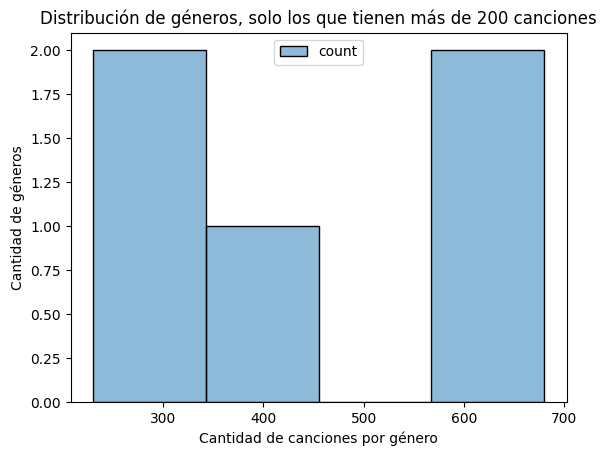

In [96]:
sns.histplot(tracks_selected.genre.value_counts().to_frame())
plt.title('Distribución de géneros, solo los que tienen más de 200 canciones')
plt.xlabel('Cantidad de canciones por género')
plt.ylabel('Cantidad de géneros')

In [ ]:
# save df as 'tracks_audio_features_selected.csv'
tracks_selected.to_csv('./datasets/tracks_audio_features_selected.csv', index=False)

Separamos los features numericos para hacer la matriz de correlacion general

In [28]:
included_types = ['float64', 'int64','category']
selected_columns = tracks_selected.select_dtypes(include=included_types).columns
selected_variables = tracks_selected[selected_columns]

included_types_num = ['float64', 'int64']
selected_columns_num = tracks_selected.select_dtypes(include=included_types_num).columns
selected_numerical = tracks_selected[selected_columns_num]

y=tracks_selected.genre

included_types_cat=['category']
selected_columns_cat = tracks_selected.select_dtypes(include=included_types_cat).columns
selected_categoricals = tracks_selected[selected_columns_cat]



Text(0.5, 1.0, 'Correlation matrix')

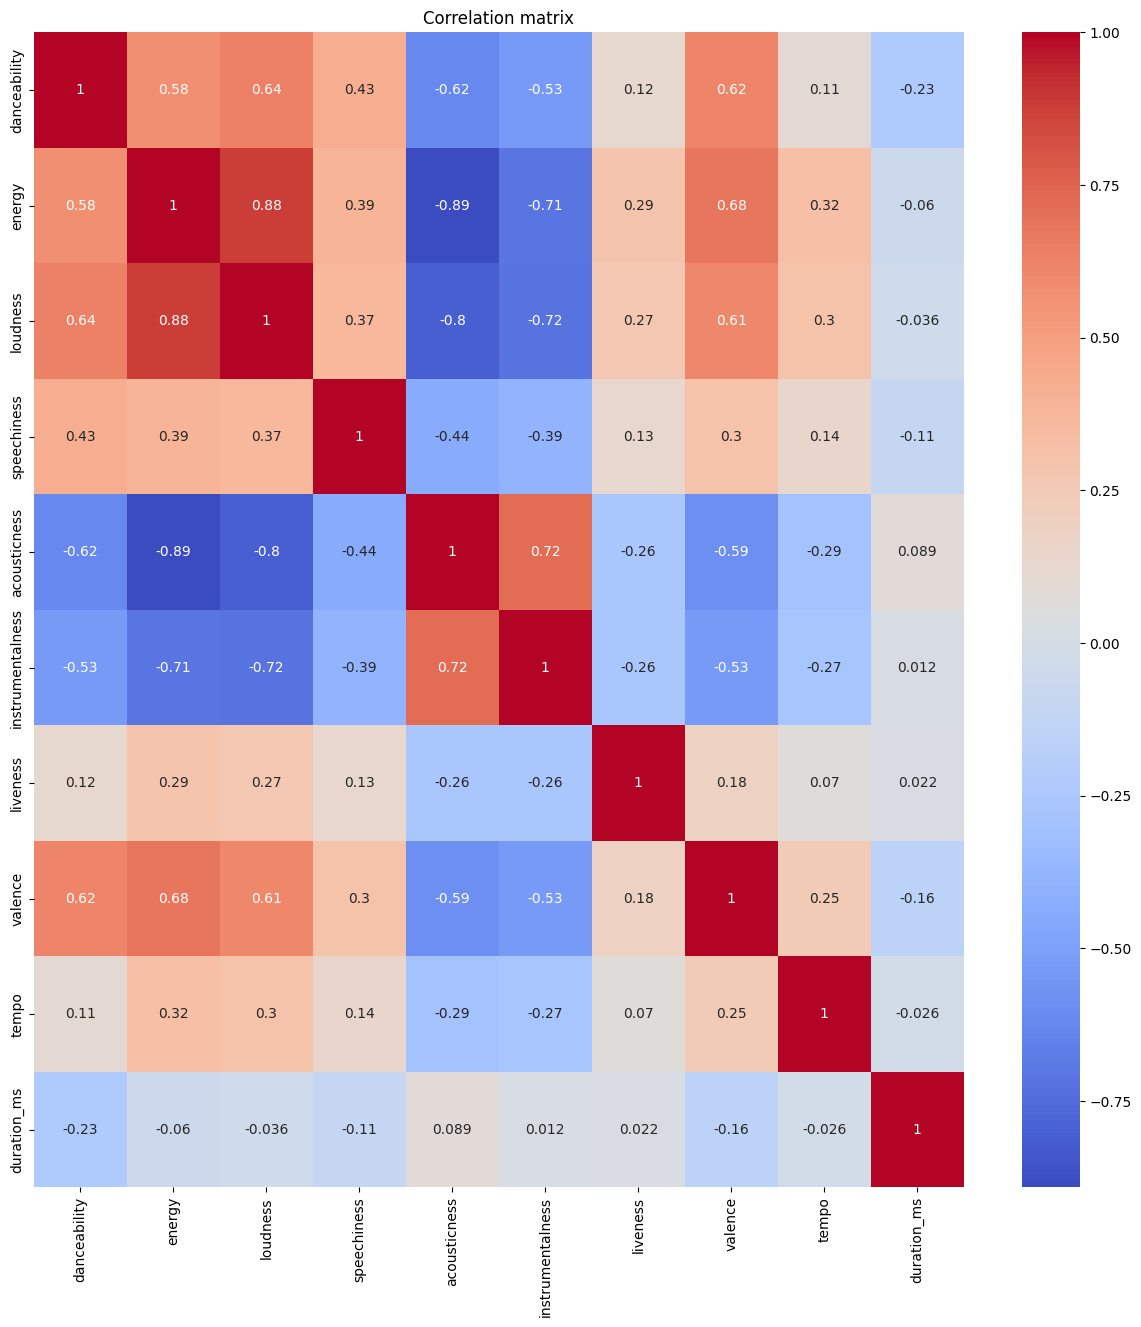

In [73]:
corr_matrix = selected_numerical.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')

Podriamos hacer la matriz de correlacion para cada genero, pero a medida que querramos agregar mas y mas generos, se nos va a hacer imposible analizarlos todos con detenimiento. Por lo que, dada la cantidad de features numericos que tenemos, vamos a realizar una reduccion dimensional para poder visualizar mejor los generos.

## PCA

In [12]:
scaler = StandardScaler()
selected_numerical_scaled = scaler.fit_transform(selected_numerical)
pca = PCA(n_components=3).fit(selected_numerical_scaled)
X_pca =  pca.transform(selected_numerical_scaled)

In [27]:
type(X_pca)

numpy.ndarray

Agregamos colores por generos

In [13]:
colormaping = y

#Coloreo a los componetes de genero
#list_generos =list(colormaping.unique())

#Usemos la lista con la que filtramos los generos! genres_selected
list_generos = genres_selected #lo pongo asi por si pinta volver atras

colors = plt.cm.rainbow(np.linspace(0, 1, len(list_generos)))
tracks_selected['color'] = colormaping.apply(lambda x: colors[list_generos.index(x)])


#Tengo que crear un diccionario de los colores para las leyendas (idk why tiene que un dic)
genre_color_map = {genre: color for genre, color in zip(list_generos, colors)}

C:\Users\admin\AppData\Local\Temp\ipykernel_2444\774826354.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


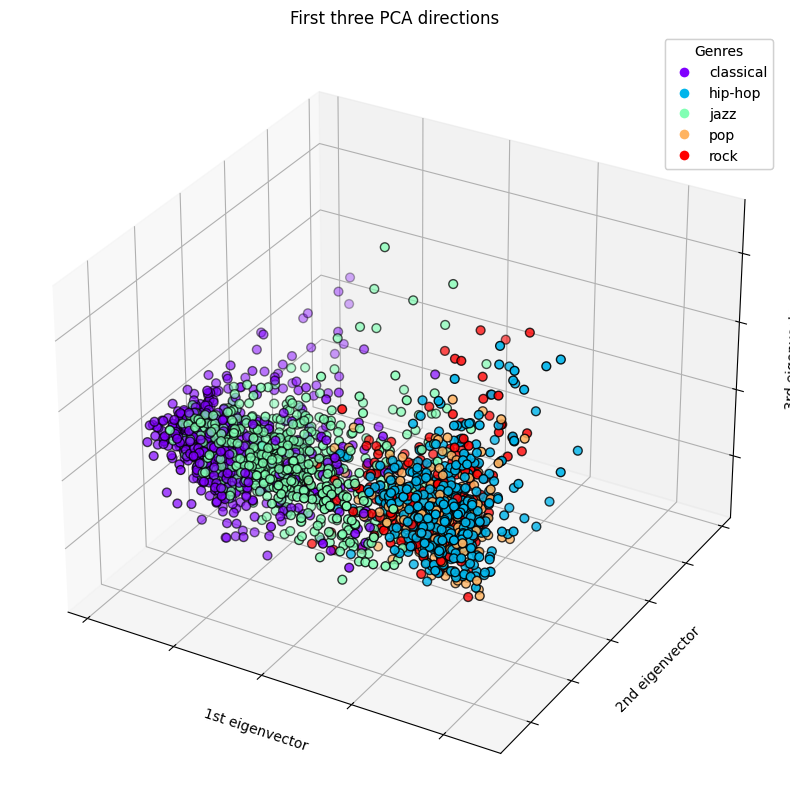

In [29]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#Grafico
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=tracks_selected['color'],#Agrego colores
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

#By ChatGPT
#Leyenda
legend_elements = []
for genre, color in genre_color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=genre))


legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)


ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])
plt.show()

In [105]:
#Ver los primeros elementos de la variancia explicada
print(pca.explained_variance_ratio_[:3]) #3 = n_components

[0.4858382  0.11349149 0.09341805]


Como los pesos de las primeras dos componentes suman el 50% de la varianza y la tercera solo aporta el 9%, grafico las 2 primeras

C:\Users\admin\AppData\Local\Temp\ipykernel_2444\2989196335.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


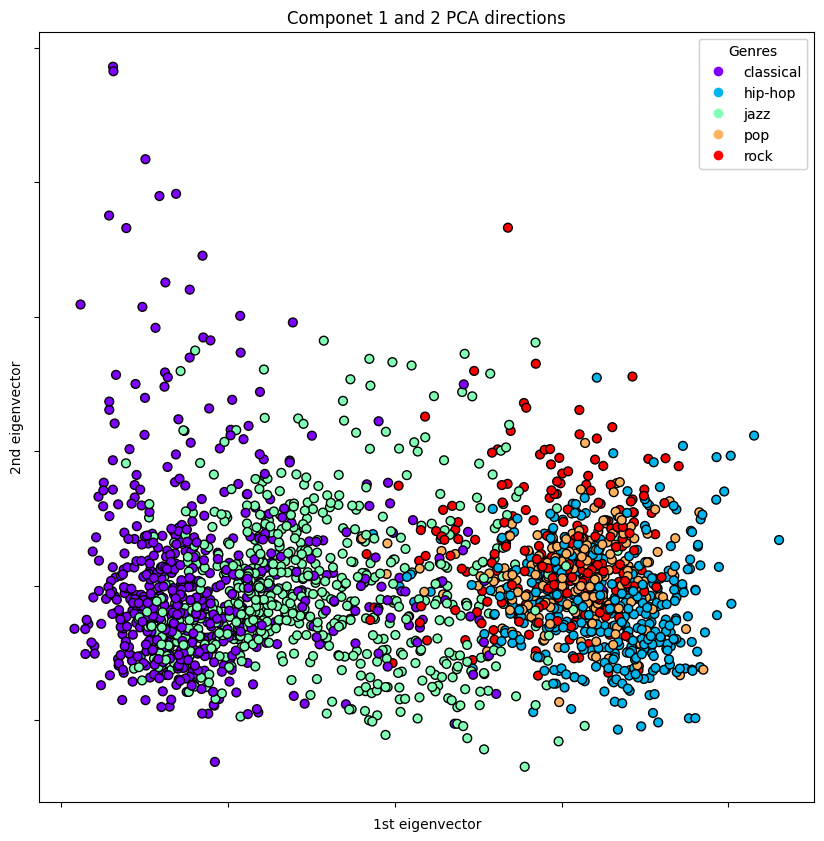

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)


ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    #X_pca[:, 2],
    c=tracks_selected['color'],#Agrego colores
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

#Leyenda
legend_elements = []
for genre, color in genre_color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=genre))


legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)


ax.set_title("Componet 1 and 2 PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
plt.show()

Buscamos cual es la cantidad de componentes que necesitamos para mantener el 95% de la varianza original del dataset

In [63]:
pca_testeo = PCA(10).fit(selected_numerical_scaled)
X_pca_testeo = pca_testeo.transform(selected_numerical_scaled)

Con 7 componentes, preservamos el 0.95 de la varianza.


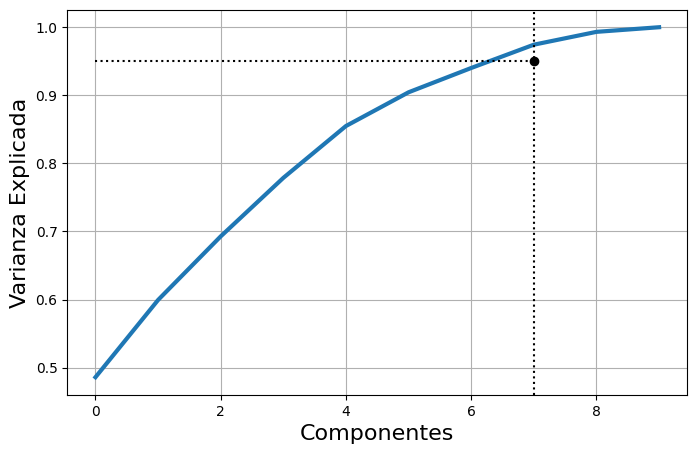

In [33]:
var_frac = 0.95


# Calcular la suma cumulativa y hacer su gráfica
cumsum = np.cumsum(pca_testeo.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac)
print('Con {} componentes, preservamos el {} de la varianza.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Componentes", fontsize=16)
plt.ylabel("Varianza Explicada", fontsize=16)

plt.grid(True)


Text(0, 0.5, 'Explained Variance Ratio')

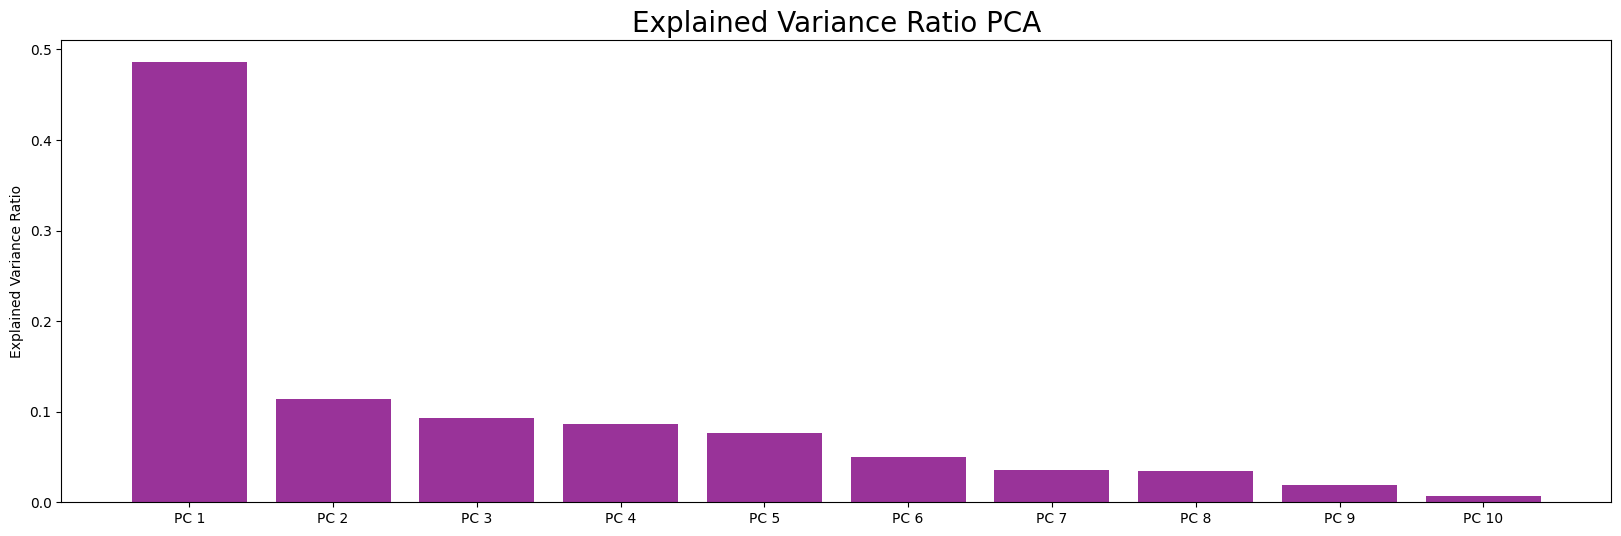

In [34]:
fig, ax = plt.subplots(ncols=1, figsize=(20,6))

ratio = pca_testeo.explained_variance_ratio_
ax.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax.set_title('Explained Variance Ratio PCA', fontsize=20)
ax.set_xticks(range(len(ratio)))
ax.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax.set_ylabel('Explained Variance Ratio')

## tSNE

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(selected_numerical_scaled)

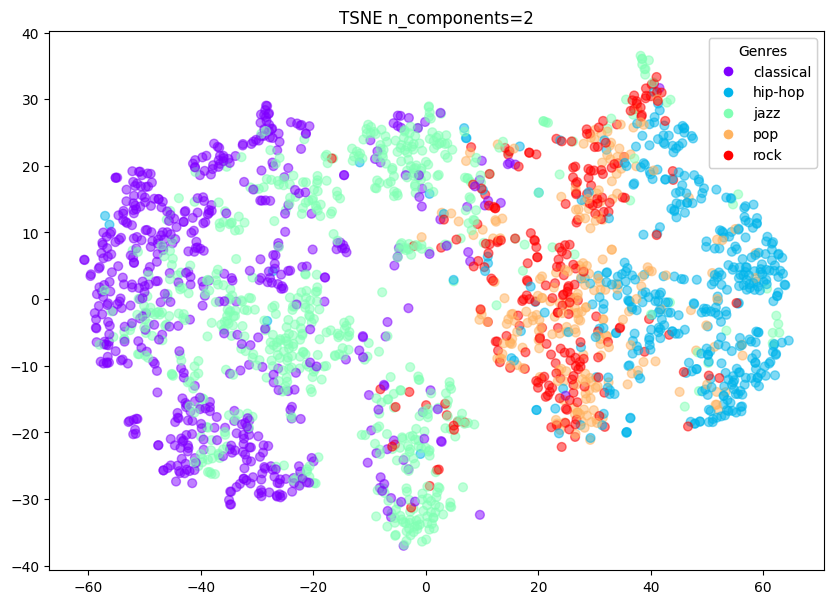

In [75]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_title("TSNE n_components=2")    
scat = ax.scatter(*X_tsne.T, 
                  c=tracks_selected['color'],  
                  s=40, 
                  alpha=0.5)
legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)

In [61]:

tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3 = tsne.fit_transform(selected_numerical_scaled)

C:\Users\admin\AppData\Local\Temp\ipykernel_10588\3638290469.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


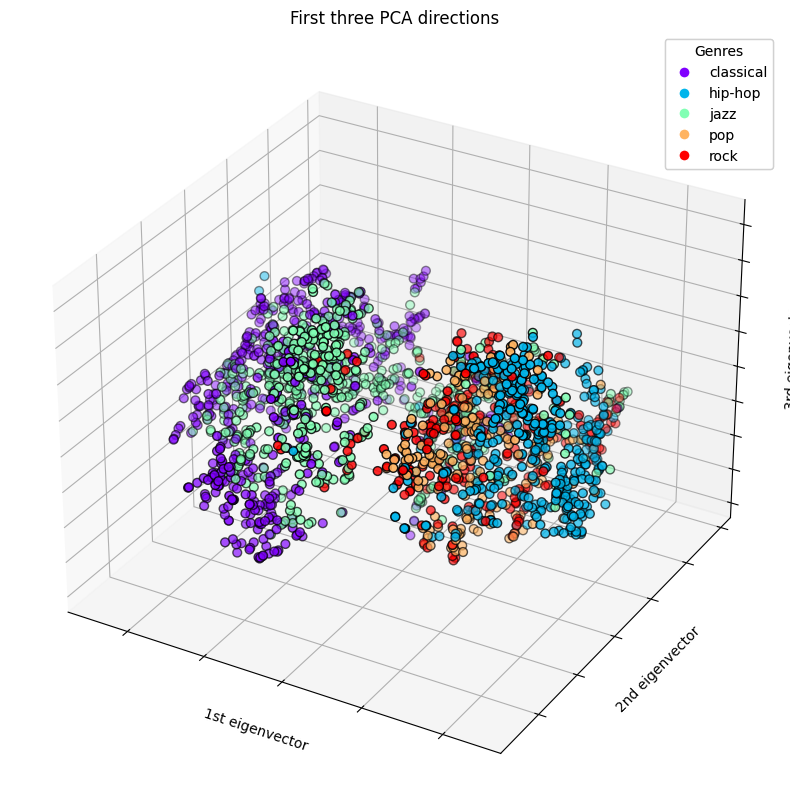

In [62]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#Grafico
scatter = ax.scatter(
    X_reduced_tsne_3[:, 0],
    X_reduced_tsne_3[:, 1],
    X_reduced_tsne_3[:, 2],
    c=tracks_selected['color'],#Agrego colores
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

#By ChatGPT
#Leyenda
legend_elements = []
for genre, color in genre_color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=genre))


legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)


ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])
plt.show()

In [15]:
pca_testeo_7 = PCA(7).fit(selected_numerical_scaled)
X_pca_testeo_7 = pca_testeo_7.transform(selected_numerical_scaled)

In [16]:
#tSNE 2 componentes con pca de 7
tsne2=TSNE(n_components=2, random_state=42)
X_pca_tsne = tsne2.fit_transform(X_pca_testeo_7)

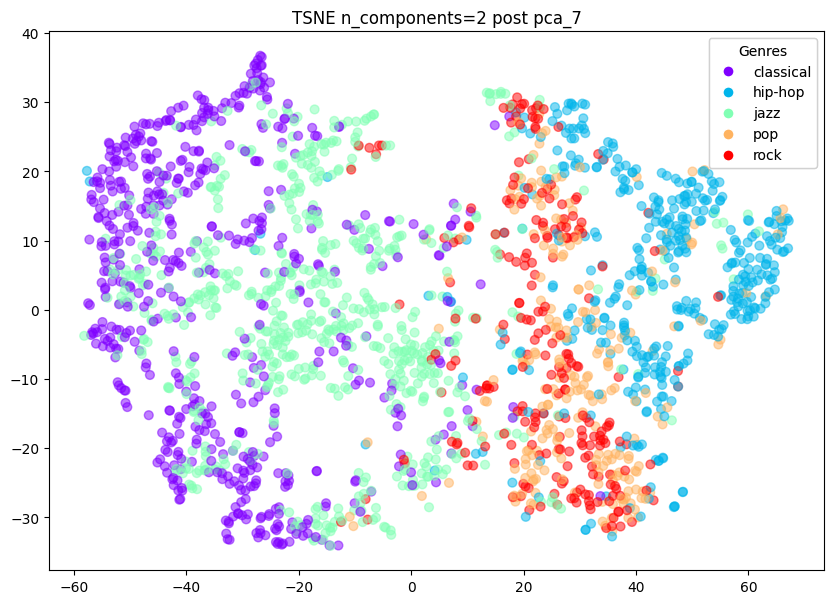

In [68]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_title("TSNE n_components=2 post pca_7")    
scat = ax.scatter(*X_pca_tsne.T, 
                  c=tracks_selected['color'],  
                  s=40, 
                  alpha=0.5)
legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)

# Modeling

### Train and Test split

Hacemos los splits para los modelos a probar, para cada caso que queremos intentar

In [38]:

#El comun 10 features (con categoricas)
svs_train,svs_test,y1_train,y1_test = train_test_split(selected_variables,y,random_state=42,test_size=0.3)

#post pca_7 (sin categoricas y scaled)
Xpca_train,Xpca_test,y2_train,y2_test = train_test_split(X_pca_testeo_7,y,random_state=42,test_size=0.3)

#post pca_7 + tsne_2 (sin categoricas y scaled)
X_pca_tsne_train,X_pca_tsne_test,y3_train,y3_test=train_test_split(X_pca_tsne,y,random_state=42,test_size=0.3)

#post tsne_2 (sin categoricas y scaled)
X_tsne_train,X_tsne_test,y4_train,y4_test=train_test_split(X_tsne,y,random_state=42,test_size=0.3)

#pruebo de agregar variables categoricas a la reduccion dimensional que mejor dio, en este caso pca_7 solo
X_pca_df = pd.DataFrame(X_pca_testeo_7,columns=[str(x) for x in range(7)])
X_pca_7_cat= pd.concat([X_pca_df,selected_categoricals.set_index(X_pca_df.index)],axis=1)

X_pca_7_cat_train,X_pca_7_cat_test,y5_train,y5_test=train_test_split(X_pca_7_cat,y,random_state=42,test_size=0.3)


In [62]:
selected_variables.shape

(2130, 13)

## Logistic Regression

Probamos para 5 variantes, el dataset como viene, pasado por 

In [39]:
reg1 = LogisticRegression(multi_class='ovr',solver='newton-cholesky')
reg2 = LogisticRegression(multi_class='ovr',solver='newton-cholesky')
reg3 = LogisticRegression(multi_class='ovr')
reg4 = LogisticRegression(multi_class='ovr')
reg5 = LogisticRegression(multi_class='ovr')


reg1.fit(svs_train,y1_train)
reg2.fit(Xpca_train,y2_train)
reg3.fit(X_pca_tsne_train,y3_train)
reg4.fit(X_tsne_train,y4_train)
reg5.fit(X_pca_7_cat_train,y5_train)



LogisticRegression(multi_class='ovr')

In [40]:
y1_pred=reg1.predict(svs_test)
y2_pred=reg2.predict(Xpca_test)
y3_pred = reg3.predict(X_pca_tsne_test)
y4_pred = reg4.predict(X_tsne_test)
y5_pred = reg5.predict(X_pca_7_cat_test)

In [41]:
acc1 = accuracy_score(y1_test,y1_pred)
acc2 = accuracy_score(y2_test,y2_pred)
acc3 = accuracy_score(y3_test,y3_pred)
acc4 = accuracy_score(y4_test,y4_pred)
acc5=accuracy_score(y5_test,y5_pred)
print(f'Solo scaled: {acc1} pca_7 {acc2} tsne_2 {acc4} pca_7+tsne_2 {acc3} pca_7+categoricas {acc5} ')

Solo scaled: 0.701095461658842 pca_7 0.6838810641627543 tsne_2 0.5805946791862285 pca_7+tsne_2 0.6025039123630673 pca_7+categoricas 0.6901408450704225 


In [70]:
def f1_calc(precision: float, recall: float) -> float:
    return (2 * precision * recall) / (precision + recall)

In [73]:
#Otras metricas
y_reg_cross_val_predict = cross_val_predict(
    reg1,
    svs_test,
    y1_test,
    cv=10
)
reg_precision = precision_score(
    y1_test,
    y_reg_cross_val_predict,
    average='macro'
)
reg_recall = recall_score(
    y1_test,
    y_reg_cross_val_predict,
    average='macro'
)

#pca7
y_reg_cross_val_predict_2 = cross_val_predict(
    reg2,
    Xpca_test,
    y2_test,
    cv=10
)
reg_precision_2 = precision_score(
    y2_test,
    y_reg_cross_val_predict_2,
    average='macro'
)
reg_recall_2 = recall_score(
    y2_test,
    y_reg_cross_val_predict_2,
    average='macro'
)

#pca_7_y_tsne
y_reg_cross_val_predict_3 = cross_val_predict(
    reg3,
    X_pca_tsne_test,
    y3_test,
    cv=10
)
reg_precision_3 = precision_score(
    y3_test,
    y_reg_cross_val_predict_3,
    average='macro'
)
reg_recall_3 = recall_score(
    y3_test,
    y_reg_cross_val_predict_3,
    average='macro'
)

#tsne
y_reg_cross_val_predict_4 = cross_val_predict(
    reg4,
    X_tsne_test,
    y4_test,
    cv=10
)
reg_precision_4 = precision_score(
    y4_test,
    y_reg_cross_val_predict_4,
    average='macro'
)
reg_recall_4 = recall_score(
    y4_test,
    y_reg_cross_val_predict_4,
    average='macro'
)

#PCA 7 + cat
y_reg_cross_val_predict_5 = cross_val_predict(
    reg5,
    X_pca_7_cat_test,
    y5_test,
    cv=10
)
reg_precision_5 = precision_score(
    y5_test,
    y_reg_cross_val_predict_5,
    average='macro'
)
reg_recall_5 = recall_score(
    y5_test,
    y_reg_cross_val_predict_5,
    average='macro'
)


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print('Logi Reg Normal')
print(f'Precision score: {reg_precision:.6f}')
print(f'Recall score: {reg_recall:.6f}')
print(f'F1 score: {f1_calc(reg_precision, reg_recall):.6f}')

print(' ')

print('Random Forest PCA 7 sin categoricas ')
print(f'Precision score: {reg_precision_2:.6f}')
print(f'Recall score: {reg_recall_2:.6f}')
print(f'F1 score: {f1_calc(reg_precision_2, reg_recall_2):.6f}')

print(' ')

print('Random Forest PCA 7 + tSNE 2')
print(f'Precision score: {reg_precision_3:.6f}')
print(f'Recall score: {reg_recall_3:.6f}')
print(f'F1 score: {f1_calc(reg_precision_3, reg_recall_3):.6f}')

print(' ')

print('Random Forest tSNE 2 ')
print(f'Precision score: {reg_precision_4:.6f}')
print(f'Recall score: {reg_recall_4:.6f}')
print(f'F1 score: {f1_calc(reg_precision_4, reg_recall_4):.6f}')

print(' ')

print('Random Forest PCA 7 + categoricas ')
print(f'Precision score: {reg_precision_5:.6f}')
print(f'Recall score: {reg_recall_5:.6f}')
print(f'F1 score: {f1_calc(reg_precision_5, reg_recall_5):.6f}')

Logi Reg Normal
Precision score: 0.605381
Recall score: 0.595083
F1 score: 0.600188
 
Random Forest PCA 7 sin categoricas 
Precision score: 0.635751
Recall score: 0.627646
F1 score: 0.631672
 
Random Forest PCA 7 + tSNE 2
Precision score: 0.437311
Recall score: 0.479079
F1 score: 0.457243
 
Random Forest tSNE 2 
Precision score: 0.462509
Recall score: 0.465686
F1 score: 0.464092
 
Random Forest PCA 7 + categoricas 
Precision score: 0.609244
Recall score: 0.604722
F1 score: 0.606975


## Random Forest

In [61]:
X_pca_testeo_7.shape

(2130, 7)

In [53]:
rf_pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('Random Forest', RandomForestClassifier(random_state=42))
])
rf_pipe_2 = Pipeline([
    ('Scaler', StandardScaler()),
    ('Random Forest', RandomForestClassifier(random_state=42))
])
rf_pipe_3 = Pipeline([
    ('Scaler', StandardScaler()),
    ('Random Forest', RandomForestClassifier(random_state=42))
])
rf_pipe_4 = Pipeline([
    ('Scaler', StandardScaler()),
    ('Random Forest', RandomForestClassifier(random_state=42))
])
rf_pipe_5 = Pipeline([
    ('Scaler', StandardScaler()),
    ('Random Forest', RandomForestClassifier(random_state=42))
])

In [43]:
rf_pipe.fit(svs_train,y1_train)
rf_pipe_2.fit(Xpca_train,y2_train)
rf_pipe_3.fit(X_pca_tsne_train,y3_train)
rf_pipe_4.fit(X_tsne_train,y4_train)
rf_pipe_5.fit(X_pca_7_cat_train,y5_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Random Forest', RandomForestClassifier(random_state=42))])

In [54]:
rf_cross_val_score = cross_val_score(
    rf_pipe,
    svs_train,
    y1_train,
    cv=10,
    scoring='accuracy'
)
rf_cross_val_score_2 = cross_val_score(
    rf_pipe_2,
    Xpca_train,
    y2_train,
    cv=10,
    scoring='accuracy'
)
rf_cross_val_score_3 = cross_val_score(
    rf_pipe_3,
    X_pca_tsne_train,
    y3_train,
    cv=10,
    scoring='accuracy'
)
rf_cross_val_score_4 = cross_val_score(
    rf_pipe_4,
    X_tsne_train,
    y4_train,
    cv=10,
    scoring='accuracy'
)
rf_cross_val_score_5 = cross_val_score(
    rf_pipe_5,
    X_pca_7_cat_train,
    y5_train,
    cv=10,
    scoring='accuracy'
)

In [55]:
print('Random Forest metrics')

print('Solo scaled')
print(f'Mean: {rf_cross_val_score.mean():.6f} ({rf_cross_val_score.std():.6f})')

print('PCA_7 componentes')
print(f'Mean: {rf_cross_val_score_2.mean():.6f} ({rf_cross_val_score_2.std():.6f})')

print('PCA_7 + tSNE_2')
print(f'Mean: {rf_cross_val_score_3.mean():.6f} ({rf_cross_val_score_3.std():.6f})')

print('tSNE_2')
print(f'Mean: {rf_cross_val_score_4.mean():.6f} ({rf_cross_val_score_4.std():.6f})')

print('pca_7 con categoricas')
print(f'Mean: {rf_cross_val_score_5.mean():.6f} ({rf_cross_val_score_5.std():.6f})')

Random Forest metrics
Solo scaled
Mean: 0.782054 (0.028567)
PCA_7 componentes
Mean: 0.720349 (0.029420)
PCA_7 + tSNE_2
Mean: 0.703544 (0.034803)
tSNE_2
Mean: 0.694855 (0.028124)
pca_7 con categoricas
Mean: 0.734438 (0.031895)


Ahora los scores de las predicciones

In [48]:
def f1_calc(precision: float, recall: float) -> float:
    return (2 * precision * recall) / (precision + recall)

In [68]:
y_rf_cross_val_predict = cross_val_predict(
    rf_pipe,
    svs_test,
    y1_test,
    cv=10
)
rf_precision = precision_score(
    y1_test,
    y_rf_cross_val_predict,
    average='macro'
)
rf_recall = recall_score(
    y1_test,
    y_rf_cross_val_predict,
    average='macro'
)

#pca_7
y_rf_cross_val_predict_2 = cross_val_predict(
    rf_pipe_2,
    Xpca_test,
    y2_test,
    cv=10
)
rf_precision_2 = precision_score(
    y2_test,
    y_rf_cross_val_predict_2,
    average='macro'
)
rf_recall_2 = recall_score(
    y2_test,
    y_rf_cross_val_predict_2,
    average='macro'
)

#pca_7_y_tsne
y_rf_cross_val_predict_3 = cross_val_predict(
    rf_pipe_3,
    X_pca_tsne_test,
    y3_test,
    cv=10
)
rf_precision_3 = precision_score(
    y3_test,
    y_rf_cross_val_predict_3,
    average='macro'
)
rf_recall_3 = recall_score(
    y3_test,
    y_rf_cross_val_predict_3,
    average='macro'
)

#tsne
y_rf_cross_val_predict_4 = cross_val_predict(
    rf_pipe_4,
    X_tsne_test,
    y4_test,
    cv=10
)
rf_precision_4 = precision_score(
    y4_test,
    y_rf_cross_val_predict_4,
    average='macro'
)
rf_recall_4 = recall_score(
    y4_test,
    y_rf_cross_val_predict_4,
    average='macro'
)

#PCA 7 + cat
y_rf_cross_val_predict_5 = cross_val_predict(
    rf_pipe_5,
    X_pca_7_cat_test,
    y5_test,
    cv=10
)
rf_precision_5 = precision_score(
    y5_test,
    y_rf_cross_val_predict_5,
    average='macro'
)
rf_recall_5 = recall_score(
    y5_test,
    y_rf_cross_val_predict_5,
    average='macro'
)


In [76]:
print('Random Forest Normal')
print(f'Precision score: {rf_precision:.6f}')
print(f'Recall score: {rf_recall:.6f}')
print(f'F1 score: {f1_calc(rf_precision, rf_recall):.6f}')

print(' ')

print('Random Forest PCA 7 sin categoricas ')
print(f'Precision score: {rf_precision_2:.6f}')
print(f'Recall score: {rf_recall_2:.6f}')
print(f'F1 score: {f1_calc(rf_precision_2, rf_recall_2):.6f}')

print(' ')

print('Random Forest PCA 7 + tSNE 2')
print(f'Precision score: {rf_precision_3:.6f}')
print(f'Recall score: {rf_recall_3:.6f}')
print(f'F1 score: {f1_calc(rf_precision_3, rf_recall_3):.6f}')

print(' ')

print('Random Forest tSNE 2 ')
print(f'Precision score: {rf_precision_4:.6f}')
print(f'Recall score: {rf_recall_4:.6f}')
print(f'F1 score: {f1_calc(rf_precision_4, rf_recall_4):.6f}')

print(' ')

print('Random Forest PCA 7 + categoricas ')
print(f'Precision score: {rf_precision_5:.6f}')
print(f'Recall score: {rf_recall_5:.6f}')
print(f'F1 score: {f1_calc(rf_precision_5, rf_recall_5):.6f}')



Random Forest Normal
Precision score: 0.708551
Recall score: 0.695212
F1 score: 0.701818
 
Random Forest PCA 7 sin categoricas 
Precision score: 0.656311
Recall score: 0.645762
F1 score: 0.650993
 
Random Forest PCA 7 + tSNE 2
Precision score: 0.631295
Recall score: 0.626741
F1 score: 0.629010
 
Random Forest tSNE 2 
Precision score: 0.627363
Recall score: 0.629916
F1 score: 0.628637
 
Random Forest PCA 7 + categoricas 
Precision score: 0.656265
Recall score: 0.644948
F1 score: 0.650557


Por las dudas probamos distintos hiperparametros

In [80]:
#Choosing best RandomForest for first case
lista_hiperparam = [x for x in range(1,11)]
rdos=[]
for hiper in lista_hiperparam:
    rf_pipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('Random Forest', RandomForestClassifier(max_features=hiper,random_state=42))
    ])
    rf_cross_val_score = cross_val_score(
        rf_pipe,
        svs_train,
        y1_train,
        cv=10,
        scoring='accuracy'
    )
    y_rf_cross_val_predict = cross_val_predict(
    rf_pipe,
    svs_test,
    y1_test,
    cv=10
    )
    rf_precision = precision_score(
        y1_test,
        y_rf_cross_val_predict,
        average='macro'
    )
    rf_recall = recall_score(
        y1_test,
        y_rf_cross_val_predict,
        average='macro'
    )
    record = ()
    record = (hiper,rf_cross_val_score.mean(),rf_precision,rf_recall,f1_calc(rf_precision, rf_recall))
    rdos.append(record)



[(1, 0.7511946308724833, 0.6973684590552534, 0.6677489626495593, 0.6822373778471359), (2, 0.7706308724832214, 0.7184286609988098, 0.6970451188828216, 0.7075753695086023), (3, 0.7820536912751679, 0.7103310706731231, 0.6864579480979651, 0.6981904964767119), (4, 0.7693154362416108, 0.7074204129998122, 0.6892881330954037, 0.6982365750584851), (5, 0.7719910514541387, 0.7342910253143152, 0.7220691489779982, 0.7281288037260876), (6, 0.7719776286353468, 0.7012852053841765, 0.6888258149757667, 0.6949996742046158), (7, 0.7686263982102909, 0.7160383400693477, 0.7006886362835434, 0.7082803340436293), (8, 0.7565548098434005, 0.7124949529809557, 0.7026231860019508, 0.7075246371071161), (9, 0.7585637583892617, 0.6940268367466971, 0.6822203391459519, 0.6880729453771558), (10, 0.7619194630872483, 0.7085512047886684, 0.6952119705886721, 0.7018182097727357)]


In [81]:
rdos

[(1,
  0.7511946308724833,
  0.6973684590552534,
  0.6677489626495593,
  0.6822373778471359),
 (2,
  0.7706308724832214,
  0.7184286609988098,
  0.6970451188828216,
  0.7075753695086023),
 (3,
  0.7820536912751679,
  0.7103310706731231,
  0.6864579480979651,
  0.6981904964767119),
 (4,
  0.7693154362416108,
  0.7074204129998122,
  0.6892881330954037,
  0.6982365750584851),
 (5,
  0.7719910514541387,
  0.7342910253143152,
  0.7220691489779982,
  0.7281288037260876),
 (6,
  0.7719776286353468,
  0.7012852053841765,
  0.6888258149757667,
  0.6949996742046158),
 (7,
  0.7686263982102909,
  0.7160383400693477,
  0.7006886362835434,
  0.7082803340436293),
 (8,
  0.7565548098434005,
  0.7124949529809557,
  0.7026231860019508,
  0.7075246371071161),
 (9,
  0.7585637583892617,
  0.6940268367466971,
  0.6822203391459519,
  0.6880729453771558),
 (10,
  0.7619194630872483,
  0.7085512047886684,
  0.6952119705886721,
  0.7018182097727357)]

Finalmente vimos que dejandolo estandar va barbaro, pero que poniendo max_features en 5 daba mejor el f1_score (para nosotros es una metrica mas representativa ya que nuestro dataset tiende a ser mas desbalanceado)

In [84]:
tracks_selected["genre"].value_counts()

genre
jazz         680
classical    572
hip-hop      409
rock         239
pop          230
Name: count, dtype: int64

EL WINNER ES EL RANDOM FOREST CON EL DATASET NORMAL CON MAX_FEATURES = 5